In [43]:
import librosa
import librosa.display

## Set Config

In [13]:
import os
from easydict import EasyDict

conf = EasyDict()

# Basic configurations
conf.sampling_rate = 44100
conf.duration = 1
conf.hop_length = 347  # to make time steps 128
conf.fmin = 20
conf.fmax = conf.sampling_rate // 2
conf.n_mels = 128
conf.n_fft = conf.n_mels * 20
conf.model = 'mobilenetv2'  # 'alexnet'

# Labels
conf.labels = ['Hi-hat', 'Saxophone', 'Trumpet', 'Glockenspiel', 'Cello', 'Knock',
               'Gunshot_or_gunfire', 'Clarinet', 'Computer_keyboard',
               'Keys_jangling', 'Snare_drum', 'Writing', 'Laughter', 'Tearing',
               'Fart', 'Oboe', 'Flute', 'Cough', 'Telephone', 'Bark', 'Chime',
               'Bass_drum', 'Bus', 'Squeak', 'Scissors', 'Harmonica', 'Gong',
               'Microwave_oven', 'Burping_or_eructation', 'Double_bass', 'Shatter',
               'Fireworks', 'Tambourine', 'Cowbell', 'Electric_piano', 'Meow',
               'Drawer_open_or_close', 'Applause', 'Acoustic_guitar',
               'Violin_or_fiddle', 'Finger_snapping']

# Training configurations
conf.folder = '.'
conf.n_fold = 1
conf.normalize = 'samplewise'
conf.valid_limit = None
conf.random_state = 42
conf.test_size = 0.01
conf.samples_per_file = 5
conf.batch_size = 32
conf.learning_rate = 0.0001
conf.epochs = 500
conf.verbose = 2
conf.best_weight_file = 'best_mobilenetv2_weight.h5'

# Runtime conficurations
conf.rt_process_count = 1
conf.rt_oversamples = 10
conf.pred_ensembles = 10
conf.runtime_model_file = os.path.join(os.path.dirname(
    os.getcwd()), 'model', 'mobilenetv2_fsd2018_41cls.pb')

conf.samples = conf.sampling_rate * conf.duration

## Recorded Sounds

In [156]:
!ls sounds/

1115003250.wav 1115011620.wav 1115071600.wav 1115081356.wav 1119144706.wav
1115003252.wav 1115011634.wav 1115071602.wav 1115081406.wav 1119144740.wav
1115003300.wav 1115011919.wav 1115071605.wav 1115081410.wav 1119144903.wav
1115003301.wav 1115011921.wav 1115071707.wav 1115081415.wav 1119145005.wav
1115003306.wav 1115011925.wav 1115071729.wav 1115081642.wav 1119145028.wav
1115003307.wav 1115024029.wav 1115072419.wav 1115081643.wav 1119145039.wav
1115003308.wav 1115024030.wav 1115072420.wav 1115081644.wav 1119145044.wav
1115003309.wav 1115024031.wav 1115072425.wav 1115081651.wav 1119145050.wav
1115003310.wav 1115024032.wav 1115072431.wav 1115081657.wav 1119145559.wav
1115004500.wav 1115024033.wav 1115072433.wav 1115081838.wav 1119145608.wav
1115004501.wav 1115024034.wav 1115074750.wav 1115081841.wav 1119145617.wav
1115004753.wav 1115024035.wav 1115074804.wav 1115081843.wav 1119145620.wav
1115004755.wav 1115024037.wav 1115074956.wav 1115081846.wav 1119145624.wav
1115005008.wav 1115024042

## Load Sound

In [157]:
fname = "./sounds/1119185550.wav"

In [158]:
y, sr = librosa.load(fname, sr=conf.sampling_rate)

# trim silence
if 0 < len(y):  # workaround: 0 length causes error
    y, _ = librosa.effects.trim(y)  # trim, top_db=default(60)

    # make it unified length to conf.samples
if len(y) > conf.samples:  # long enough
    pass
    # cut long file
    # y = y[0:0+conf.samples]
else:  # pad blank
    padding = conf.samples - len(y)    # add padding at both ends
    offset = padding // 2
    y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')

In [159]:
y.shape

(57856,)

## Pitch Detection

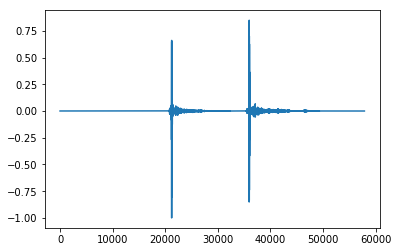

In [160]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(y)

In [161]:
import numpy as np

y_stft = np.abs(librosa.stft(y, n_fft=conf.n_fft))

In [162]:
y_stft.shape

(1281, 91)

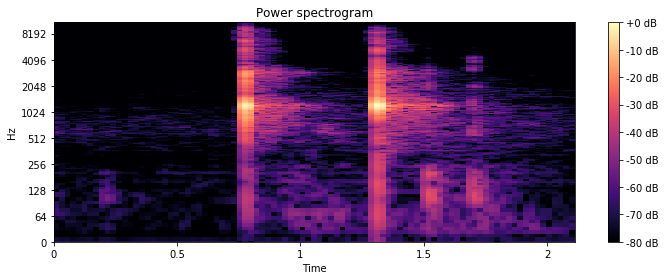

In [163]:
plt.figure(figsize=(10,4))
librosa.display.specshow(librosa.amplitude_to_db(y_stft, ref=np.max), y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
 
plt.tight_layout()
plt.show()

In [164]:
librosa.fft_frequencies(sr=conf.sampling_rate, n_fft=conf.n_fft)

array([0.00000000e+00, 1.72265625e+01, 3.44531250e+01, ...,
       2.20155469e+04, 2.20327734e+04, 2.20500000e+04])

In [165]:
y_stft.shape

(1281, 91)

In [166]:
freqs_list = librosa.fft_frequencies(sr=conf.sampling_rate, n_fft=conf.n_fft)
freqs_list.shape

(1281,)

## Pitch Estimation

In [167]:
playfreq = freqs_list[np.argmax(np.median(y_stft, axis=1))]
playfreq

1240.3125

In [168]:
import IPython.display as ipd

ipd.Audio(fname) # load a local WAV file

In [169]:
sr = 44100 # sample rate
T = 3.0    # seconds
t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
x = 0.5 * np.sin(2 * np.pi * playfreq * t)                # pure sine wave at 440 Hz
ipd.Audio(x, rate=sr) # load a NumPy array